In [3]:
# Import Necessary Libraries
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image


In [4]:
# Data Loading and Preprocessing
def load_and_preprocess_data(data_dir, image_size=128, batch_size=64):
    """
    Load and preprocess the dataset from a single folder of images.
    """
    from PIL import Image

    class CustomImageDataset(torch.utils.data.Dataset):
        def __init__(self, root_dir, transform=None):
            self.root_dir = root_dir
            self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir)]
            self.transform = transform

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image, 0  # Returning 0 as dummy label since we don't need labels.

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),  # Normalize to [-1, 1] for GANs
    ])

    # Create dataset
    dataset = CustomImageDataset(data_dir, transform=transform)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    print(f"Loaded {len(dataset)} images from {data_dir}")
    return data_loader


In [5]:
# Visualize Dataset
def visualize_data(data_loader, num_images=16):
    """
    Visualize a batch of images from the DataLoader.
    """
    data_iter = iter(data_loader)
    images, _ = next(data_iter)
    images = images[:num_images]

    grid = torchvision.utils.make_grid(images, nrow=4, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.axis("off")
    plt.show()
    print("Data visualization complete.")


In [6]:
# Save and Load Checkpoints
def save_checkpoint(model, optimizer, epoch, checkpoint_path="checkpoint.pth"):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch}.")

def load_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Checkpoint loaded. Resuming training from epoch {start_epoch}.")
    return start_epoch

In [7]:
# Visualize Generated Images
def visualize_generated_images(generator, latent_dim, device, epoch, num_images=16):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, latent_dim, 1, 1, device=device)
        fake_images = generator(noise).cpu()
        fake_images = (fake_images.clamp(-1, 1) + 1) / 2  # Normalize to [0, 1]

        grid = torchvision.utils.make_grid(fake_images, nrow=4, normalize=True)
        plt.figure(figsize=(8, 8))
        plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
        plt.axis("off")
        plt.title(f"Generated Images - Epoch {epoch}")
        plt.show()


In [8]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, latent_dim, image_channels, feature_maps):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, feature_maps * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.InstanceNorm2d(feature_maps * 8, affine=True),
            nn.ReLU(True),

            # State: (feature_maps * 8) x 4 x 4
            nn.ConvTranspose2d(feature_maps * 8, feature_maps * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(feature_maps * 4, affine=True),
            nn.ReLU(True),

            # State: (feature_maps * 4) x 8 x 8
            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(feature_maps * 2, affine=True),
            nn.ReLU(True),

            # State: (feature_maps * 2) x 16 x 16
            nn.ConvTranspose2d(feature_maps * 2, feature_maps, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(feature_maps, affine=True),
            nn.ReLU(True),

            # State: (feature_maps) x 32 x 32
            nn.ConvTranspose2d(feature_maps, image_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # Output: image_channels x 64 x 64
        )

    def forward(self, x):
        return self.model(x)


In [9]:
# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, image_channels, feature_maps):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input: image_channels x 64 x 64
            nn.Conv2d(image_channels, feature_maps, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # State: feature_maps x 32 x 32
            nn.Conv2d(feature_maps, feature_maps * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # State: (feature_maps * 2) x 16 x 16
            nn.Conv2d(feature_maps * 2, feature_maps * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # State: (feature_maps * 4) x 8 x 8
            nn.Conv2d(feature_maps * 4, feature_maps * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # State: (feature_maps * 8) x 4 x 4
            nn.Conv2d(feature_maps * 8, 1, kernel_size=4, stride=1, padding=0)
        )

    def forward(self, x):
        # Convolutional layers
        x = self.model(x)

        # Global average pooling to reduce to a single scalar per image
        return x.view(x.size(0), -1).mean(dim=1)


In [10]:
# Training Loop
def train_dcgan(generator, discriminator, data_loader, num_epochs, device, latent_dim, lr=0.0002, beta1=0.5, checkpoint_path="dcgan_checkpoint.pth"):
    # Loss function
    criterion = nn.BCEWithLogitsLoss()

    # Optimizers
    optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

    # Move models to the device
    generator.to(device)
    discriminator.to(device)

    # Resume from checkpoint if available
    start_epoch = 0
    try:
        start_epoch = load_checkpoint(checkpoint_path, generator, optimizer_g)
        print(f"Resuming training from epoch {start_epoch}.")
    except FileNotFoundError:
        print("No checkpoint found. Starting from scratch.")

    for epoch in range(start_epoch, num_epochs):
        g_loss_epoch, d_loss_epoch = 0.0, 0.0
        progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for real_images, _ in progress_bar:
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # Labels
            real_labels = torch.ones(batch_size, device=device)
            fake_labels = torch.zeros(batch_size, device=device)

            # =======================
            # Train Discriminator
            # =======================
            optimizer_d.zero_grad()

            # Real images
            outputs_real = discriminator(real_images)
            d_loss_real = criterion(outputs_real, real_labels)

            # Fake images
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_images = generator(noise)

            outputs_fake = discriminator(fake_images.detach())
            d_loss_fake = criterion(outputs_fake, fake_labels)

            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_d.step()

            # =======================
            # Train Generator
            # =======================
            optimizer_g.zero_grad()

            # Fake images through discriminator
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)

            g_loss.backward()
            optimizer_g.step()

            # Accumulate loss for progress display
            g_loss_epoch += g_loss.item()
            d_loss_epoch += d_loss.item()

            progress_bar.set_postfix({"D Loss": d_loss.item(), "G Loss": g_loss.item()})

        # Visualize generated images at the end of the epoch
        visualize_generated_images(generator, latent_dim, device, epoch+1)

        # Save checkpoint
        save_checkpoint(generator, optimizer_g, epoch+1, checkpoint_path)

        print(f"Epoch {epoch+1} completed: Generator Loss = {g_loss_epoch:.4f}, Discriminator Loss = {d_loss_epoch:.4f}")


In [11]:
# Hyperparameters
latent_dim = 100
image_channels = 3
feature_maps = 64
num_epochs = 50
lr = 0.0002
beta1 = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Loaded 63565 images from /content/drive/MyDrive/Deep_Learning_Projects/Anime_Face_Generation /Anime_Face_Dataset/images


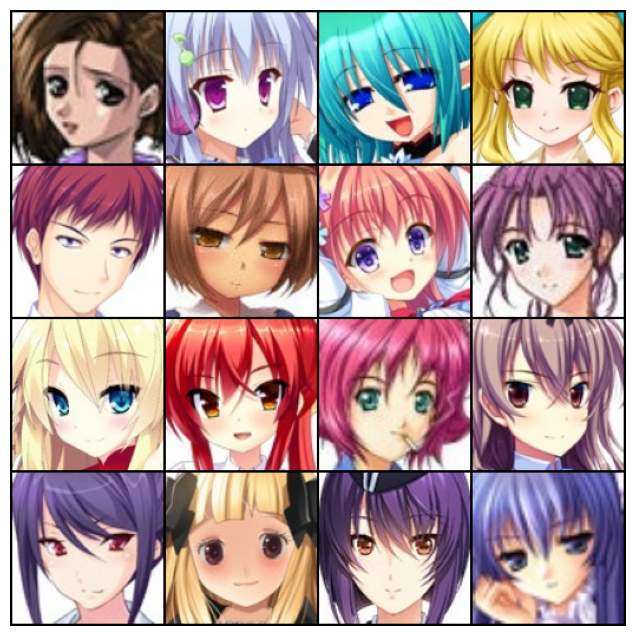

Data visualization complete.


In [13]:
# Load and Preprocess Data
data_dir = "/content/drive/MyDrive/Deep_Learning_Projects/Anime_Face_Generation /Anime_Face_Dataset/images"
data_loader = load_and_preprocess_data(data_dir)
visualize_data(data_loader)


In [14]:
# Initialize models
generator = Generator(latent_dim, image_channels, feature_maps)
discriminator = Discriminator(image_channels, feature_maps)


In [15]:
# Checkpoint
checkpoint_path = "dcgan_checkpoint.pth"


In [ ]:
# Train DCGAN
train_dcgan(generator, discriminator, data_loader, num_epochs, device, latent_dim, lr, beta1, checkpoint_path)


In [17]:
# Generating an image
def generate_and_plot_image(generator, latent_dim, device):
    # Set the generator to evaluation mode
    generator.eval()

    # Generate a random latent vector
    latent_vector = torch.randn(1, latent_dim, 1, 1, device=device)  # Shape: [1, latent_dim, 1, 1]

    # Generate a fake image
    with torch.no_grad():  # No gradients needed for inference
        fake_image = generator(latent_vector).cpu().squeeze(0)  # Shape: [C, H, W]

    # Post-process the image (scale from [-1, 1] to [0, 1])
    fake_image = (fake_image + 1) / 2  # Rescale to [0, 1]

    # Plot the image
    plt.figure(figsize=(4, 4))
    if fake_image.shape[0] == 1:  # Grayscale image
        plt.imshow(fake_image.squeeze(0), cmap="gray")
    else:  # RGB image
        plt.imshow(fake_image.permute(1, 2, 0))  # Shape: [H, W, C]
    plt.axis("off")
    plt.title("Generated Image")
    plt.show()


In [ ]:
generate_and_plot_image(generator, latent_dim=100, device=device)